# Load neural libraries and neural network

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from skimage.transform import rescale, resize, downscale_local_mean

In [0]:
import os
import torch
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import timeit
import random

import matplotlib.pyplot as plt
import numpy as np

def imageBatch(nb_image):
    imgBatchR_T = torch.randint(0,255,(nb_image,3,9,9))
    imgBatchL_T = imgBatchR_T
    labelT = torch.ones(nb_image,1)

    imgBatchR_F = torch.randint(0,255,(nb_image,3,9,9)) #
    imgBatchL_F = torch.randint(0,255,(nb_image,3,9,9))
    labelF = torch.zeros(nb_image,1)

    finalR = torch.cat((imgBatchR_T,imgBatchR_F))
    finalL = torch.cat((imgBatchL_T,imgBatchL_F))
    finalLabel = torch.cat((labelT,labelF))

    return finalR, finalL, finalLabel

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

def firstStageCNN():
    return nn.Sequential(#nn.Conv2d(3,1,2),
                         #nn.ReLU(inplace=True),

                         #Flatten(),

                         nn.Linear(3*9*9, 50), #L1
                         nn.ReLU(inplace=True),
                         
                         nn.Linear(50, 50), #L2
                         nn.ReLU(inplace=True))

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = firstStageCNN()
        
        self.cnn2 = firstStageCNN()

        
        self.fc = nn.Sequential(nn.Linear(100, 75), #L3
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(75, 50), #L4
                                nn.ReLU(inplace=True),
                            
                                nn.Linear(50, 25), #L5
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(25, 1), #L6
                                nn.Sigmoid())
    
    def forward(self, input1, input2):
        output1 = self.cnn1(input1.float().view(-1,3*9*9))
        output2 = self.cnn2(input2.float().view(-1,3*9*9))


        combined = torch.cat((output1.view(output1.size(0), -1),
                              output2.view(output2.size(0), -1)), dim=1)

        combined = torch.unsqueeze(combined,2)
        combined = torch.unsqueeze(combined,3)
        combined = combined.view(-1,100)
        
        out = self.fc(combined)
        
        return out

In [0]:
net = torch.load("/content/disparity_NN (1).pth")

# First attempt starts here

In [0]:
'''Compares two squares of (at the moment 9x9 size - adjustable if neural net is retrained)
and gives a 'likeliness' value for it, meaning that the ones with the highest likeliness
value can be selected to generate the disparity map'''
def compare(left_square, right_square): #here we define the compare function-other people are working on it
    return net(torch.from_numpy(left_square), torch.from_numpy(right_square))
     

In [0]:
'''Iterates through all the pixels of the image and calls the "find_matching_pixel" 
function for each one - also generates a depthmap based on the absolute depth at the same time'''
def find_all_pixels(left_image, right_image, square_size, nth_pixel_checked, sa_height, sa_width):
  depthmap = np.zeros((len(left_image), len(left_image[0])))
  # j loops in x direction, i loops in y direction
  for i in range(square_size, len(left_image)-1):
    for j in range(square_size, len(left_image[0])-1, nth_pixel_checked):
      x, y = find_matching_pixel(left_image, right_image, square_size, nth_pixel_checked, sa_height, sa_width, j, i)
      # print("jixy:",j,i,x,y)
      disparity = np.sqrt((x-j)**2+(y-i)**2)
      # print(disparity)
      depthmap[i][j] = depth(disparity)
    plt.figure()
    plt.imshow(depthmap)
    plt.show()
  return depthmap


In [0]:
'''Iterates through a preset search area and finds the best matching pixel so that
after calling this function for each pixel on the image a depthmap can be generated'''
def find_matching_pixel(left_image, right_image, square_size, nth_pixel_checked, sa_height, sa_width, x, y):
        #you go to left picture and pick an initial pixel and the square size are around it
        # print(x+square_size+1)
        # print(y+square_size+1)
        left_square = left_image[y-square_size:y+square_size+1, x-square_size:x+square_size+1] 
    
        #define search area in which I look for same pixels (that will be at the RIGHT image)
        #start of search area
        starting_x = max(square_size, x-sa_width) # make sure doesn't go outside of actual image 
        starting_y = max(square_size, y-sa_height)
        #end of search area
        ending_x = min(len(left_image[0])-square_size, x)
        ending_y = min(len(left_image)-square_size, y+sa_height+1)

        #now I need to see how much the two areas are alike (LIKELINESS), then figure out to which pixel on left image that corresponds (BEST MATCH) 
        highest_likeness = 0 #at the beginning, before comparing the picture, the likeliness is 0
        best_match_position = (0,0) #your initial best match is 0
        best_i, best_j = y,x
        # i loops in y direction, j in x direction
        for i in range(starting_y, ending_y): #for every i and
            for j in range(starting_x, ending_x, nth_pixel_checked): #for every j in the search area
                right_square = right_image[i-square_size:i+square_size+1, j-square_size:j+square_size+1] #define right image and from which to which element it goes
        #by now I have itinerated through every part pixel (and its square_size surroundings) of the search area  
                #rint(right_square)
                # print(left_square.shape)
                if(left_square.shape == (square_size*2+1, square_size*2+1, 3)):
                  likeness = compare(left_square, right_square) #this function will compare the likeness of each right square to the left square
                else:
                  likeness = -1
                if likeness >= highest_likeness: #if the new likeness is bigger than the set highest likeness (at the beginning, 0)
                  highest_likeness = likeness #set your new likeness as your highest likeliness
                  best_i, best_j = i, j#also, set your best match position (to which the new highest likeness corresponds) to their new values i, j
        #now you know where the pixel from the left image is located on the right image! :D   
        # print(x, y, best_j, best_i)     
        return best_j, best_i

In [0]:
''' computes absolute distance based on the disparity of the pixel '''
def depth(disparity):
    # f=1 #focal length of the camera
    # B=0.2 #distance between camera centers
    # z=f*B/disparity #z is depth-you get distance in meters
    #scaling of z: what is the furthest away point? depends on in which environment we intend to use it.150?
    # max_distance=150
    # deep=255#scale it to get a scale 0-255
    return disparity

# Second attempt starts here

In [0]:
def rescale_img(imageL, imageR):
    x = rescale(imageL, (1.28,float(640/1242),1), anti_aliasing=True)
    y = rescale(imageR, (1.28,float(640/1242),1), anti_aliasing=True)
    return np.array(x), np.array(y)

if __name__ == '__main__': #This is the main function that can then call the other functions
    square_size = 4 #we can modify later (nn will figure out what value fits best)
    nth_pixel_checked = 1 # the location of every nth (where n is the value of the variable) pixel will be checked (NN modifies later)
    sa_height, sa_width = 2, 30 # height of area searched, width of area searched (NN modifies later)
    # generate random "images" (matrices) - before we get real NN
    left_image = plt.imread("road_left_jpeg.jpeg")[:,:,:3]
    right_image = plt.imread("road_right_jpeg.jpeg")
    left_image = left_image[:,:,:3]
    right_image = right_image[:,:,:3]
    print(left_image.shape)
    left_image, right_image = rescale_img(left_image, right_image)
    left_image, right_image = np.array(left_image), np.array(right_image)
    print(left_image.shape)
    # print(left_image)
    # left_image = np.random.rand(480,640,3)
    # right_image = np.random.rand(480,640,3)
    # print(left_image.shape)
    # print(left_image)
    left_image = np.pad(left_image,[(square_size, square_size), (square_size, square_size), (0,0)], constant_values=-1)
    right_image = np.pad(right_image,[(square_size, square_size), (square_size, square_size), (0,0)], constant_values=-1)
    # just visualized the input images
    plt.imshow(left_image)
    plt.figure()
    plt.imshow(right_image)
    plt.show()
    # calls find_pixels function and passes all the arguments
    depthmap = find_all_pixels(left_image, right_image, square_size, nth_pixel_checked, sa_height, sa_width) 
    plt.figure()
    plt.imshow(depthmap)
    plt.show()

(488, 648)
[[0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 ...
 [0.3 0.3 0.3 ... 1.  1.  0.3]
 [0.3 0.3 0.3 ... 1.  1.  0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]]


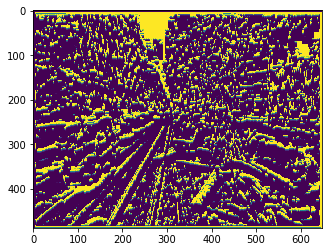

In [0]:
depthmap_edited = depthmap
print(depthmap_edited.shape)
depthmap_edited = np.clip(depthmap_edited, 0.03, 0.1)
depthmap_edited=depthmap_edited/0.1
print(depthmap_edited)
plt.imshow(depthmap_edited)

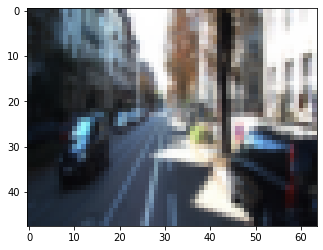

(48, 64, 3)
(48, 64)


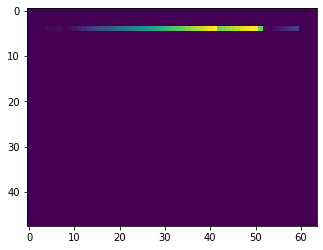

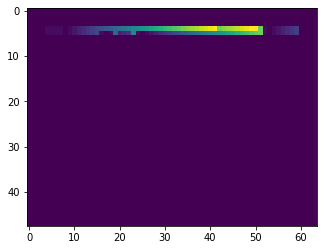

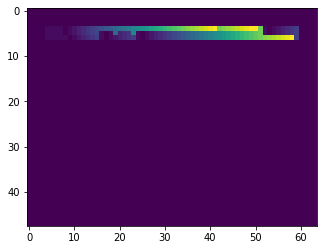

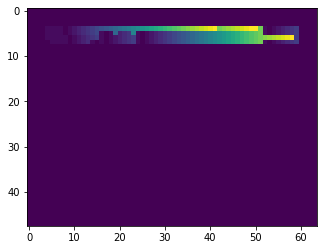

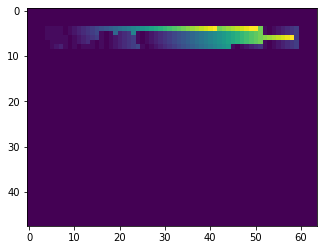

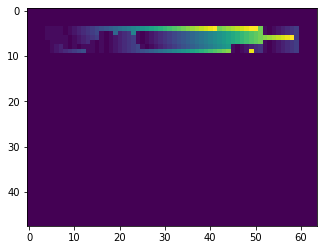

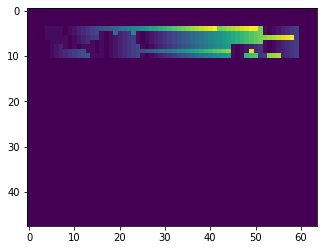

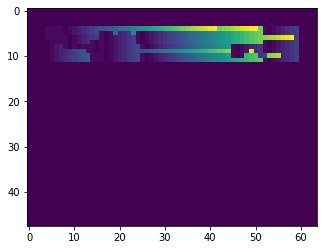

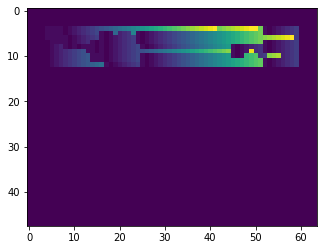

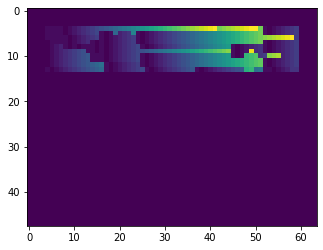

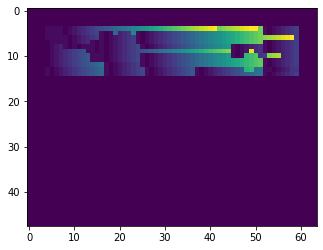

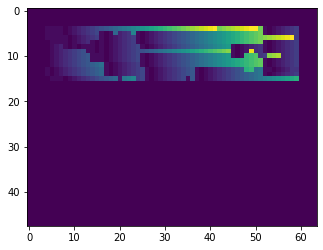

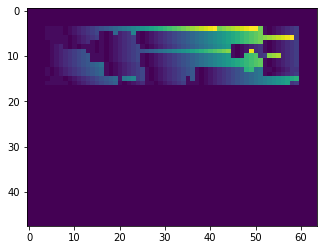

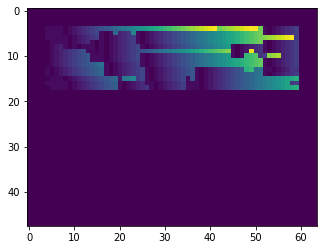

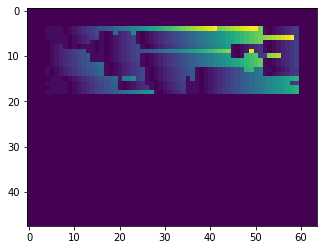

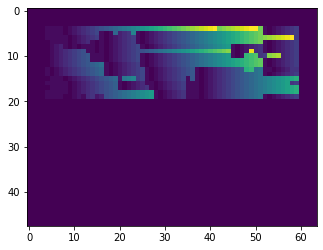

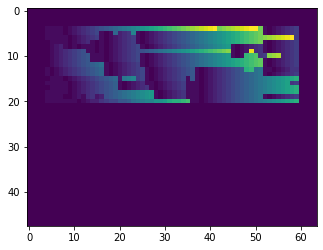

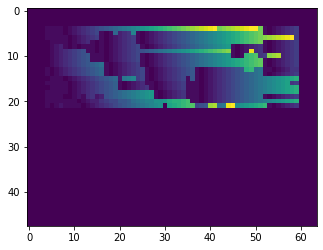

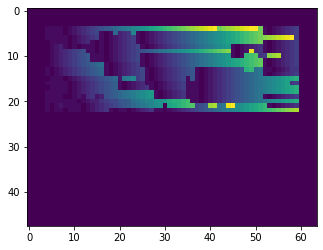

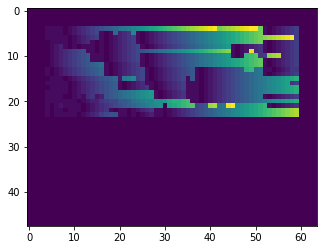

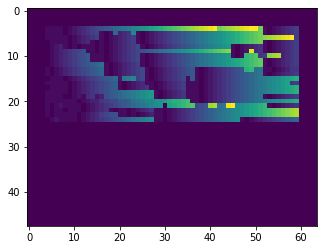

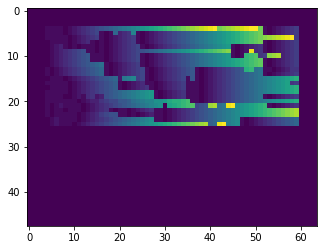

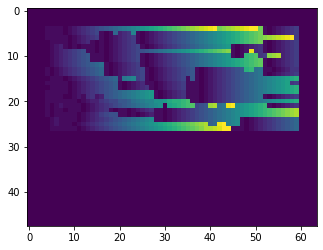

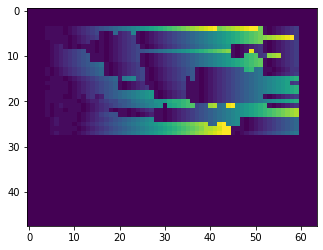

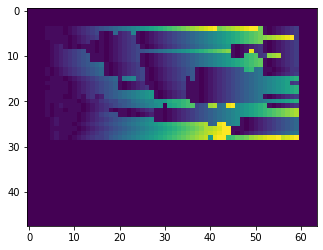

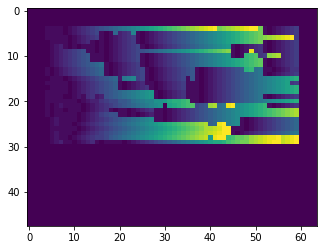

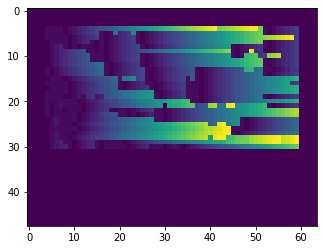

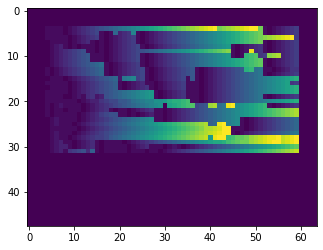

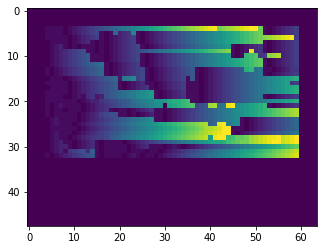

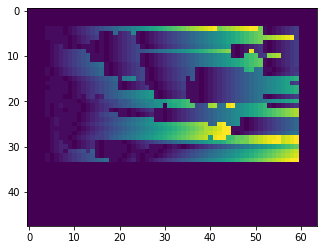

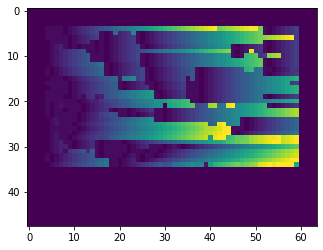

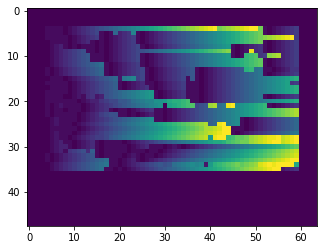

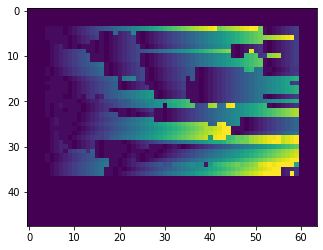

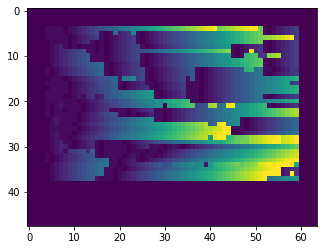

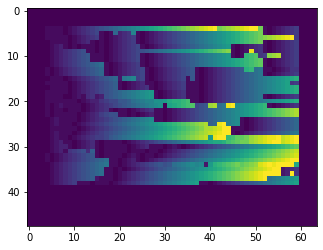

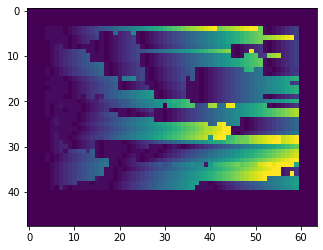

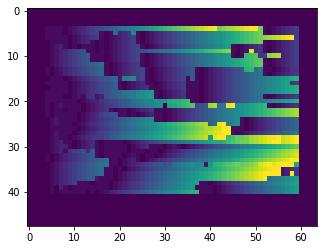

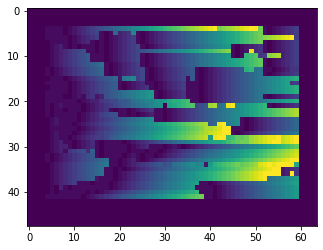

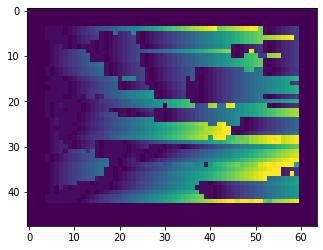

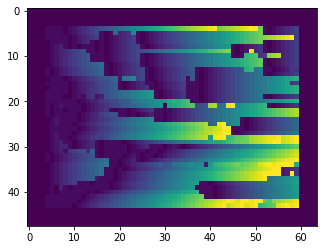

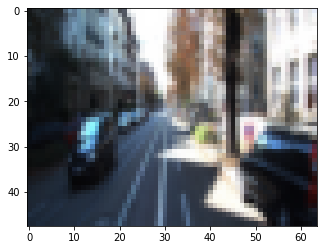

In [214]:
import numpy as np
import matplotlib.pyplot as plt

def rescale_img(y_scale, x_scale, imageL, imageR):
    x = rescale(imageL, (y_scale,x_scale,1), anti_aliasing=True)
    y = rescale(imageR, (y_scale,x_scale,1), anti_aliasing=True)
    return np.array(x), np.array(y)


left_image = plt.imread("/content/road_left_jpeg.jpeg")
right_image = plt.imread("/content/road_right_jpeg.jpeg")
left_image, right_image = rescale_img(1.28,float(640/1242), left_image, right_image)
left_image, right_image = rescale_img(0.1,0.1, left_image, right_image)
plt.imshow(left_image)
plt.imshow(right_image)
plt.show()

offset = 2 # how much to the right the search box should be offset
square_size = 4
search_width = 35
search_height = 0
# matrix[y,x] y comes first!!!!
def find_matching_pixel(x,y):
  
  # just so the it's still matrix[y,x] otherwise passing the values flips it - 
  # this is just to avoid confusion (might be counterproductive though)
  backup_x = x
  x = y
  y = backup_x
  
  left_square = left_image[y-square_size:y+square_size+1, x-square_size:x+square_size+1] # +1 needed to get 9x9 pixel
  # left_image[y-square_size:y+square_size+1, x-square_size:x+square_size+1] = 1
  starting_x = max(square_size, x-search_width+offset)
  ending_x = min(len(left_image[0]) - square_size, x+offset)
  starting_y = max(square_size, y-search_height)
  ending_y = min(len(left_image)-square_size ,y+search_height+1)
  # i iterates through y, j iterates through x
  highest_alike = 0
  alike = 0
  best_i, best_j = y, x
  for i in range(starting_y, ending_y):
    for j in range(starting_x, ending_x):
      # left_image[i,j] = [0,0,1]
      right_square = right_image[i-square_size:i+square_size+1, j-square_size:j+square_size+1] # +1 needed to get 9x9 pixels
      # alike = 1
      alike = compare(left_square, right_square)
      if alike > highest_alike:
        # print("alike updated from", highest_alike, "to", alike)
        highest_alike = alike
        best_i, best_j = i,j
  # returns best x and best y
  # print(x, y, best_j, best_i, left_square.size)
  return best_j, best_i
  
print(left_image.shape)
matrix = np.zeros((len(left_image),len(left_image[0])))
print(matrix.shape)
# find_matching_pixel(40,10)
# count = 0
disparity_list = []
for y in range(square_size, len(matrix)-square_size):
  for x in range(square_size, len(matrix[0])-square_size):
    best_x, best_y = find_matching_pixel(y,x)
    # print(best_x, best_y, x, y)
    disparity = np.sqrt((best_x-x)**2 - (best_y-y)**2)
    disparity_list.append(disparity)
    matrix[y,x] = disparity
    # matrix[y,x] = count
    # count+=1
  plt.imshow(matrix) 
  plt.show()
# find_matching_pixel(matrix, 50, 10)
plt.imshow(matrix)
# left_image[40,10] = [100,0,0]
plt.imshow(left_image)
plt.show()

# Visualization of how Method 2 works here 

In [0]:
''' BACKUP VERSION WHERE ITERATION WORKS PROPERLY'''



import numpy as np
import matplotlib.pyplot as plt

offset = 2 # how much to the right the search box should be offset
square_size = 3
search_width = 10
search_height = 1
# matrix[y,x] y comes first!!!!
def find_matching_pixel(matrix,x,y):
  
  # just so the it's still matrix[y,x] otherwise passing the values flips it - 
  # this is just to avoid confusion (might be counterproductive though)
  backup_x = x
  x = y
  y = backup_x
  
  left_square = matrix[y-square_size:y+square_size+1, x-square_size:x+square_size+1] # +1 needed to get 9x9 pixel
  matrix[y-square_size:y+square_size+1, x-square_size:x+square_size+1] = 2
  starting_x = max(square_size, x-search_width+offset)
  ending_x = min(len(matrix[0]) - square_size, x+offset)
  starting_y = max(square_size, y-search_height)
  ending_y = min(len(matrix)-square_size ,y+search_height+1)
  # i iterates through y, j iterates through x
  count = 3
  for i in range(starting_y, ending_y):
    for j in range(starting_x, ending_x):
      matrix[i,j] = count
      count+=1
  print(x, y, left_square.size)

matrix = np.zeros((70,40))
count = 0
for y in range(square_size, len(matrix)-square_size):
  for x in range(square_size, len(matrix[0])-square_size):
    matrix[y,x] = count
    count+=1
    # find_matching_pixel(matrix,x,y)
find_matching_pixel(matrix, 20, 30)
plt.imshow(matrix)